# Read in the data

In [1]:
import pandas 
import numpy 
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [11]:
survey_fields

['DBN',
 'rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_10',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

Text(0,0.5,'Correlation with sat_score')

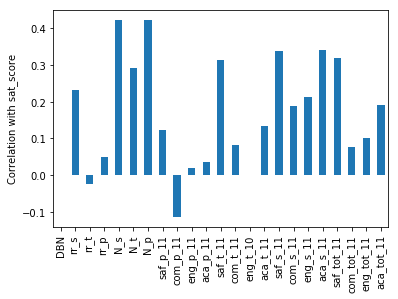

In [12]:
fig, ax = plt.subplots()
ax = combined.corr()["sat_score"][survey_fields].plot.bar()
ax.set_ylabel("Correlation with sat_score")

# Consult the data dictionary that's part of the zip file you can download from the City of New York's website.
Did you find any surprising correlations?

N_s, N_p have high correlations with sat_score, which are strongly related to the former discovery of the correlation between total_enrollment and sat_score. we just confirm it again with a different angle of view to show that the larger the number of students, the better the sat_score achieved.

saf_s_11, saf_t_11, and saf_tot_11 all appear high correlations with sat_score, which make sense that people no matter students or teachers, learning or teaching are all performed well when they are in an environment they feel safe.

The most interesting correlation between aca_s_11 and sat_score tells us that how students feel about that quality of academy also plays an important role of how real sat_score performed, which indicates that we should take students' reponse more seriously since it reflects to the real situation closely.   

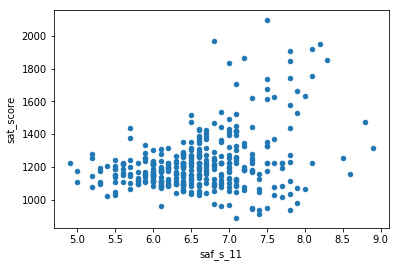

In [13]:
combined.plot(x="saf_s_11", y="sat_score", kind="scatter")

There is a correlation between saf_s_11 and sat_score even though it's not very strong. 

In [14]:
dist = combined.groupby("CSD")[["saf_s_11", "saf_t_11", "lon", "lat"]].mean()
dist.reset_index(inplace=True)

In [15]:
dist["avg_safety"]= dist[["saf_s_11", "saf_t_11"]].apply(numpy.mean, axis=1)
dist["nor_avg_safety"] = dist["avg_safety"]/dist["avg_safety"].max()
dist

,CSD,saf_s_11,saf_t_11,lon,lat,avg_safety,nor_avg_safety
0,1,6.768611,7.066667,-73.982377,40.719022,6.917639,0.910216
1,2,6.910660,7.404167,-73.991386,40.739699,7.157413,0.941765
2,3,6.716667,6.675000,-73.977370,40.781574,6.695833,0.881031
3,4,6.885714,7.871429,-73.943215,40.793449,7.378571,0.970865
4,5,6.314286,6.857143,-73.949251,40.817077,6.585714,0.866541
5,6,6.950000,7.490000,-73.932502,40.848970,7.220000,0.950000
6,7,6.800000,6.969231,-73.919971,40.816815,6.884615,0.905870
7,8,6.364697,7.109091,-73.866087,40.823803,6.736894,0.886433
8,9,6.655000,6.935000,-73.906240,40.836349,6.795000,0.894079
9,10,6.577273,6.972727,-73.898360,40.870345,6.775000,0.891447


/Users/dia/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/dia/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/dia/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dia/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


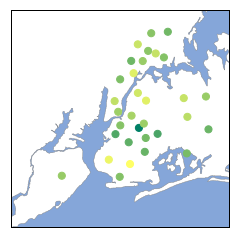

In [16]:
fig, ax = plt.subplots()
m = Basemap(projection="merc", llcrnrlat=40.496044, urcrnrlat=40.915256, llcrnrlon=-74.255735 , urcrnrlon=-73.700272, resolution="f")

cst = (127/255, 127/255, 127/255)
m.drawcoastlines(color=cst, linewidth=.4)
m.drawmapboundary(fill_color="#85A6D9")
m.fillcontinents(color="white")

lon = dist["lon"].tolist()
lat = dist["lat"].tolist()

m.scatter(lon, lat, latlon=True, s=50, zorder=2, c=dist["nor_avg_safety"], cmap="summer")

plt.show()

It shows lower Brooklyn, parts of Queens, and upper side of Manhattan have higher safety scores than other places.

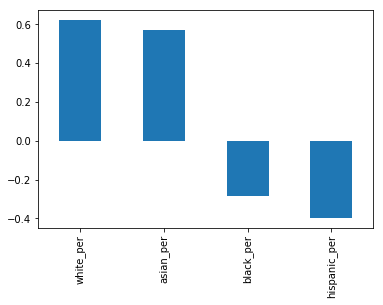

In [17]:
races= ["white_per", "asian_per", "black_per", "hispanic_per"]

races_corr = combined.corr()["sat_score"][races].plot.bar()

We can see that white_per and asian_per both have strong positive correlations with sat_score, which may the be result of those races have more traditonal values for family and society, which means they take care of their children more and give them more resources to support their growth. As a result, their children may be healthier both physically and mentally and also being encouranged to study more without worrying finacil conditions, which makes these group of people to perform well on an academy field.

black_per and hispanic_per have strong negtive correaltions with sat_score, whcih may due to the reason of their culture emphasizes more on developments of individual interests rather than just focusing on academic study. 

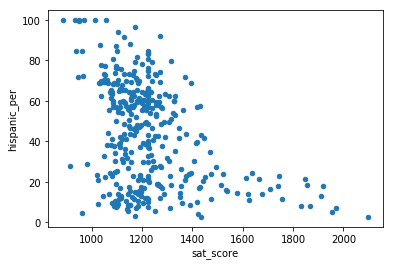

In [18]:
combined.plot.scatter(x="sat_score", y="hispanic_per")

In [19]:
combined.loc[(combined.sat_score < 1000) & (combined.hispanic_per > 60), ["SCHOOL NAME", "sat_score", "hispanic_per"]]

,SCHOOL NAME,sat_score,hispanic_per
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,945.0,71.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
126,BRONX INTERNATIONAL HIGH SCHOOL,965.0,72.2
139,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,962.0,84.7
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8
179,HIGH SCHOOL OF WORLD CULTURES,939.0,84.6
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0


Schools for sat_score under 1000 and hispanic_per greater than 60 are almost related to international schools. Using English which is not first language for them to learn academic subjects may be the main reason for resulting low sat_score performance.

In [20]:
combined.loc[combined.hispanic_per > 95, ["SCHOOL NAME", "sat_score", "hispanic_per"]]

,SCHOOL NAME,sat_score,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0


All of these schools with hispanic_per greater than 95 tends to have majority of international students who are learning English, which is the reason to have poor SAT perfromance. 

In [21]:
combined.loc[(combined.sat_score > 1800) & (combined.hispanic_per < 10), ["SCHOOL NAME", "sat_score", "hispanic_per"]]

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3


Schools for sat_score higher than 1800 and hispanic_per lower than 10 are almost specilized in science and technoledge. However, the low hispanic_per doesn't explain the outcome above, but we know all students are all over New York City where has higher academic standard since before.

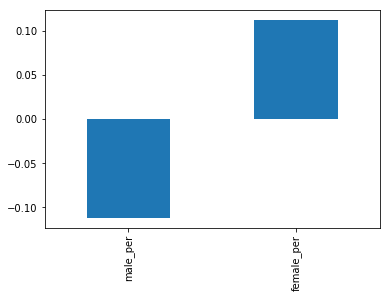

In [22]:
gender_corr = combined.corr()["sat_score"][["male_per", "female_per"]]
gender_corr.plot.bar()

Accroding to the plot above, it tells that females have a positive correlation with sat_score, and males have a negative one.
We may infer that females may be more mature and more responsible for their studies during high school age. 

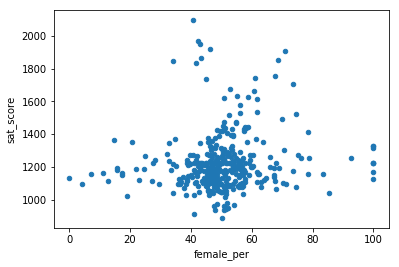

In [23]:
combined.plot.scatter(x="female_per", y="sat_score")

No correlation appeares in the plot above; however, there is a cluster of schools with 40 t0 60 percentages of females and lower sat scores.

In [24]:
combined.loc[(combined.female_per > 60) & (combined.sat_score > 1700), ["SCHOOL NAME", "female_per", "sat_score"]]

,SCHOOL NAME,female_per,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0


All these schools with high values in both female_per and sat_score usually have liberal arts subjects within them, which can be related to the preference of subjects women choose to study and to the intrinsic ability women have in general, and it might also be the little confirmation of the correlation between female_per and sat_score we did before. 

In [25]:
combined["ap_per"] = combined["AP Test Takers "]/ combined["total_enrollment"]
combined["ap_per"]

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
         ...   
333    0.029536
334    0.084567
335    0.877747
336    0.053398
337    0.268251
338    0.260664
339    0.307945
340    0.082513
341    0.119905
342    0.142857
343    0.055616
344    0.127682
345    0.143466
346    0.293247
347    0.242535
348    0.316247
349    0.123853
350    0.036117
351    0.090191
352    0.096787
353    0.102194
354    0.086031
355    0.191154
356    0.478261
357    0.356433
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 36

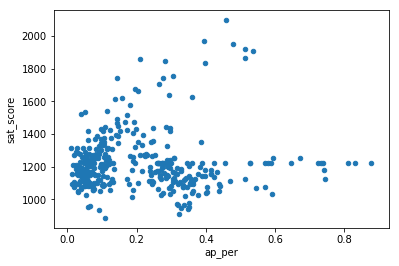

In [26]:
combined.plot.scatter(x="ap_per", y="sat_score")

A part of those schools whose ap_per under around 0.5 shows a very weak correlation between the rate of AP test takers and the SAT scores.
As the increament of the percentage of AP test takers takes, the value of SAT scores reaches to its peak as well. 

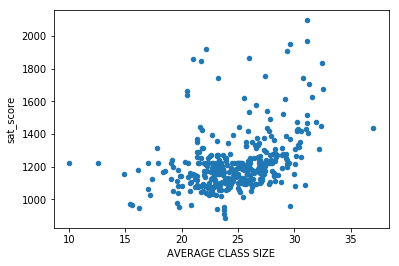

In [27]:
combined.plot.scatter(x = "AVERAGE CLASS SIZE", y="sat_score")

In [28]:
combined.corr()["sat_score"]["AVERAGE CLASS SIZE"]

0.38101433080955233

The correaltion between class size and SAT score is not very weak, but the correlation value is up to 0.38, which may be the result of a cluster of aggregated schools in the lower part of the plot.